### KNN model
#### 2 fits using-  flattened input and convoluted input
#### print best k value and mse, plot image, check residuals  

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import tensorflow as tf
from sklearn.neighbors import KNeighborsRegressor
import random
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import time

#### preprocess

In [2]:
%%time
# preprocess: data import, shuffle, switch axes, flattening , convolution. detailed in notebk 'rgb_data_load_mod.ipynb'.

b = np.load('../Downloads/depth_training_data.npz') # 3500 images of rgb and depth
data_rgb = b['rgb_images']                # RGB DATA 
data_depth = b['depth_maps']              # DEPTH DATA 
data_rgb = data_rgb/255        # normalize input
data_depth = data_depth - data_depth.min()      # normalize output 
# switch axes for plotting
data_rgb = data_rgb.transpose(0,2,3,1)
data_depth = data_depth.transpose(0,2,3,1)
# shuffle images
random.seed(400)
random.shuffle(data_depth)     # inplace method
random.seed(400)
random.shuffle(data_rgb)

# change to 32 bit floats
data_rgb = data_rgb.astype(np.float32)       # size(type) modification for nn 
data_depth = data_depth.astype(np.float32)

# flatten
X = data_rgb.reshape(data_rgb.shape[0],27648)        
Y = data_depth.reshape(data_depth.shape[0],9216)
# running small data of 1.4k images for conv. as kernel keeps dying on larger sizes. 
data_rgb, data_depth = data_rgb[:1400], data_depth[:1400] 
X,Y = X[:1400],Y[:1400]
#conv

input_shape = data_rgb.shape
x = data_rgb  # no padding, strides default
y = tf.keras.layers.Conv2D(128, 3, activation='relu', input_shape=input_shape[1:])(x)
x_f = tf.keras.layers.MaxPool2D()(y)
x_f.shape
y1 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_f)
y1.shape
x_ff = tf.keras.layers.MaxPool2D()(y1)
x_ff.shape
y11 = tf.keras.layers.Conv2D(96, 3, activation='relu')(x_ff)
y11.shape
x_fff = tf.keras.layers.MaxPool2D()(y11)
x_fff.shape
x_fff = tf.keras.layers.GlobalAveragePooling2D()(x_fff) 

xconv = x_fff.numpy()

2022-01-05 00:33:55.837290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 38.4 s, sys: 1min, total: 1min 39s
Wall time: 1min 15s


#### KNN using gridcv and flattened input. 

{'n_neighbors': 1}


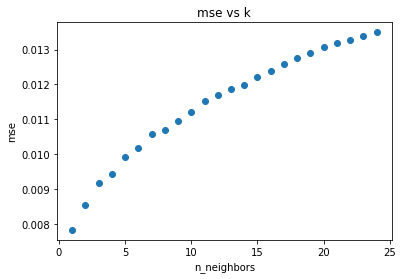

knn best score occurred for k=1, the best score was 0.0078
time for knn using flattened i/p: 4.932695253616667 minutes


In [3]:
tic1=time.perf_counter()

knn = KNeighborsRegressor()
# create a dictionary of all values we want to test for n_neighbors
maxK= 25
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors

knn_gscv = GridSearchCV(knn, param_grid, return_train_score=True, cv=5, scoring = "neg_mean_squared_error")
#fit model to data
knn_gscv.fit(X, Y)

#check top performing n_neighbors value
print(knn_gscv.best_params_)
#plt.plot(knn_gscv.cv_results_['mean_test_score'])
plt.scatter(np.arange(1,maxK),-knn_gscv.cv_results_['mean_test_score'])
plt.ylabel('mse')
plt.xlabel('n_neighbors')
plt.title("mse vs k")
plt.show()

#check mean score for the top performing value of n_neighbors
print(f"knn best score occurred for k={knn_gscv.best_index_ +1}, the best score was {np.abs(knn_gscv.best_score_):3.2}")

toc1=time.perf_counter()
print("time for knn using flattened i/p:",(toc1-tic1)/60,"minutes")

In [4]:
np.abs(knn_gscv.cv_results_['mean_test_score'])

array([0.00783495, 0.0085546 , 0.00918774, 0.00944689, 0.00991033,
       0.01017985, 0.0105863 , 0.01069317, 0.0109574 , 0.01121156,
       0.01151378, 0.01170742, 0.01186516, 0.01199862, 0.01221983,
       0.0123971 , 0.01257972, 0.01274571, 0.01291464, 0.01305799,
       0.01317556, 0.0132839 , 0.01339527, 0.01349174])

#### KNeighborsRegressor with Convoluted X data

{'n_neighbors': 2}


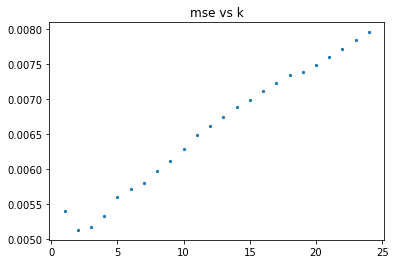

knn best score occurred for k=2, the best score was 0.0051
time for knn using flattened i/p: 1.213 minutes


In [5]:
tic2=time.perf_counter()
knn = KNeighborsRegressor()
# create a dictionary of all values we want to test for n_neighbors
maxK= 25
param_grid = {'n_neighbors': np.arange(1, 25)}
knn1_gscv = GridSearchCV(knn, param_grid, return_train_score=True, cv=5, scoring = "neg_mean_squared_error")
#fit model to data
knn1_gscv.fit(xconv, Y)

#check top performing n_neighbors value
print(knn1_gscv.best_params_)
#plt.plot(knn_gscv.cv_results_['mean_test_score'])
plt.scatter(np.arange(1,maxK),np.abs(knn1_gscv.cv_results_['mean_test_score']),s=5)
plt.title("mse vs k")
plt.show()

#check mean score for the top performing value of n_neighbors
print(f"knn best score occurred for k={knn1_gscv.best_index_ + 1}, the best score was {np.abs(knn1_gscv.best_score_):3.2}")
toc2=time.perf_counter()

print(f"time for knn using flattened i/p: {(toc2-tic2)/60 :3.5} minutes")

In [6]:
print("mse scores for all k values, 1 to 100",np.abs(knn1_gscv.cv_results_['mean_test_score']))

mse scores for all k values, 1 to 100 [0.00540197 0.00513055 0.00517754 0.00532349 0.00559981 0.00571017
 0.00579411 0.00596871 0.00611962 0.00628954 0.00648572 0.00660906
 0.0067474  0.00688294 0.00699045 0.00711196 0.00722508 0.00734322
 0.00738741 0.00749299 0.00759617 0.00771639 0.00785003 0.00795388]


#### Predicting with models (k=1 to 15) & displaying images- Knn with Convolved x 

In [7]:
#Splitting data into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(xconv,Y, test_size= 0.20, random_state = 98)

colorimg_train, colorimg_test = train_test_split(data_rgb, test_size= 0.20, random_state = 98)

/var/folders/c2/jbhr2bnj1_gcm3xlnsq8jv8h0000gn/T/ipykernel_14909/2868817682.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()


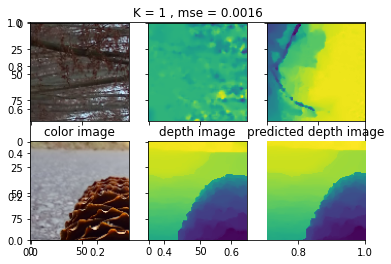

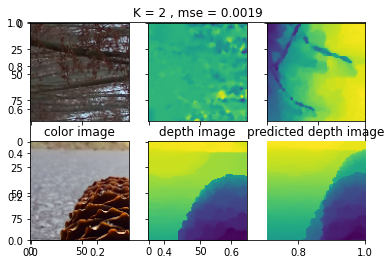

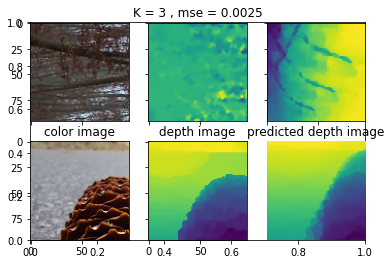

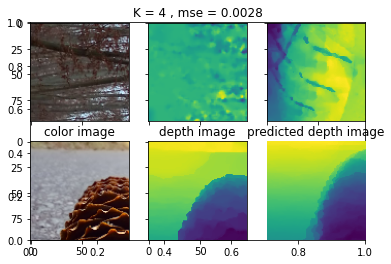

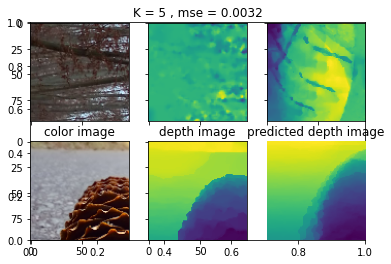

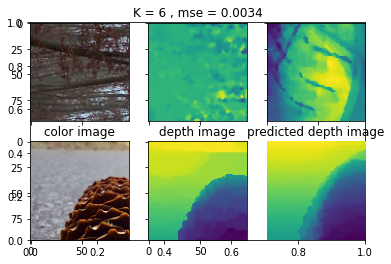

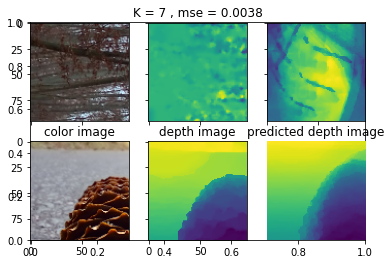

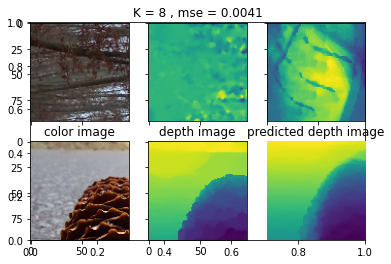

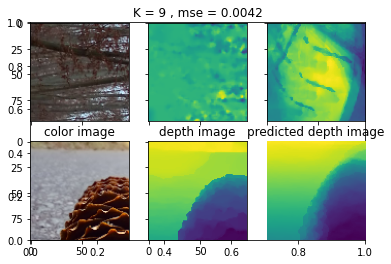

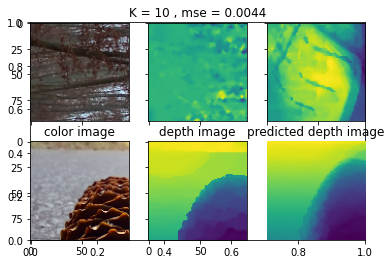

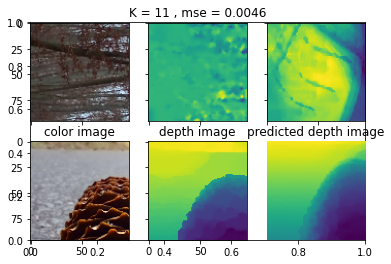

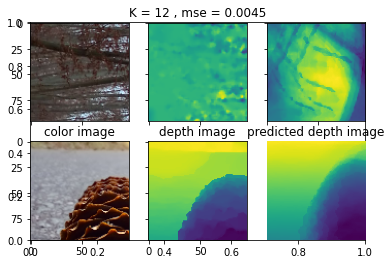

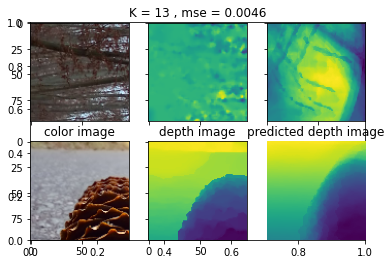

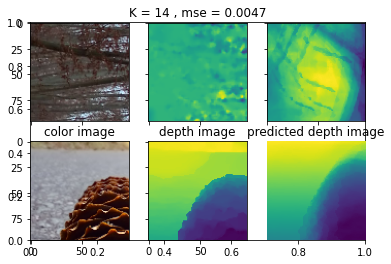

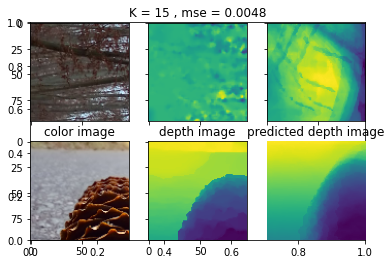

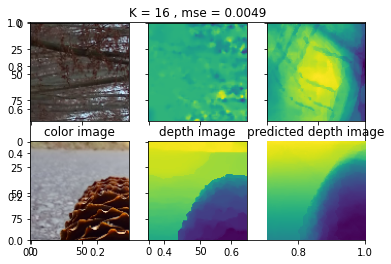

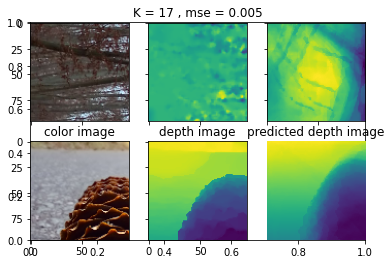

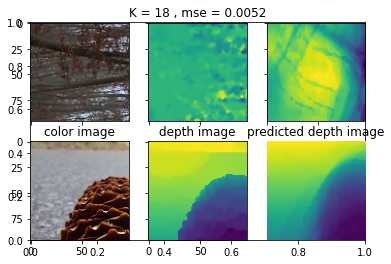

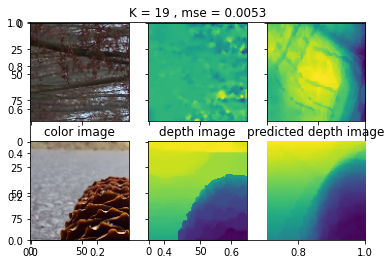

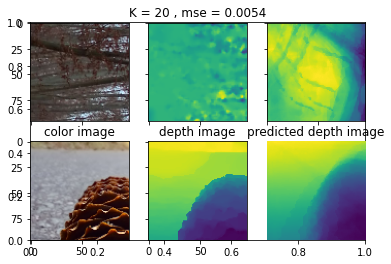

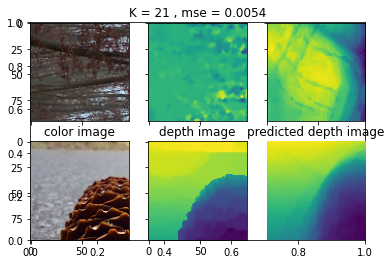

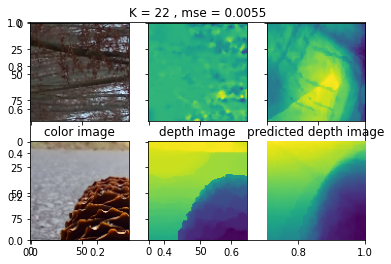

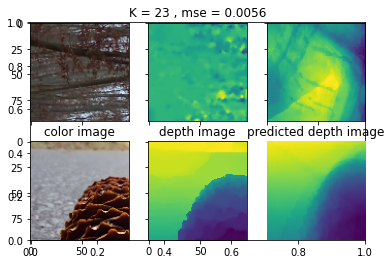

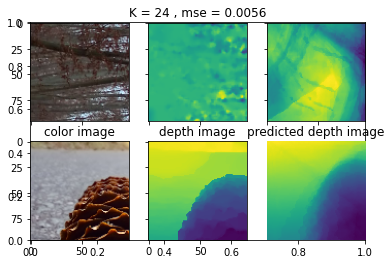

In [8]:
for k in range(1,25):
    knn = KNeighborsRegressor(n_neighbors= k)
    m = knn.fit(x_train, y_train)
    ypred = m.predict(x_test)
    mse = mean_squared_error(ypred, y_test)
    f = plt.figure()
    plt.title(f"K = {k} , mse = {mse :3.2}")
    axarr = f.subplots(2,3)
    plt.axis("off")
    axarr[0,0].imshow(colorimg_test[21])
    axarr[0,1].imshow(y_test[21].reshape(96,96,1))
    axarr[0,2].imshow(ypred[21].reshape(96,96,1))
    axarr[1,0].imshow(colorimg_test[30])
    axarr[1,1].imshow(y_test[30].reshape(96,96,1))
    axarr[1,2].imshow(ypred[30].reshape(96,96,1))
    axarr[1,0].set_title('color image')
    axarr[1,1].set_title('depth image')
    axarr[1,2].set_title('predicted depth image')
    for ax in axarr.flat:
        ax.label_outer()

#### Plotting more images with k<15 , it is better for learning when images have more detail in them 

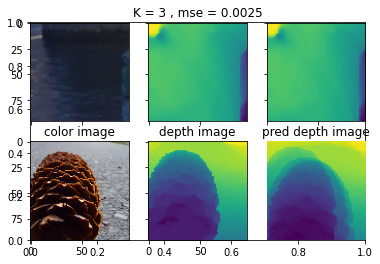

In [10]:
knn = KNeighborsRegressor(n_neighbors= 3)
m = knn.fit(x_train, y_train)
ypred = m.predict(x_test)
mse = mean_squared_error(ypred, y_test)
f = plt.figure()
plt.title(f"K = 3 , mse = {mse :3.2}")
axarr = f.subplots(2,3)
plt.axis("off")
axarr[0,0].imshow(colorimg_test[11])
axarr[0,1].imshow(y_test[11].reshape(96,96,1))
axarr[0,2].imshow(ypred[11].reshape(96,96,1))
axarr[1,0].imshow(colorimg_test[15])
axarr[1,1].imshow(y_test[15].reshape(96,96,1))
axarr[1,2].imshow(ypred[15].reshape(96,96,1))
axarr[1,0].set_title('color image')
axarr[1,1].set_title('depth image')
axarr[1,2].set_title('pred depth image')
for ax in axarr.flat:
    ax.label_outer()

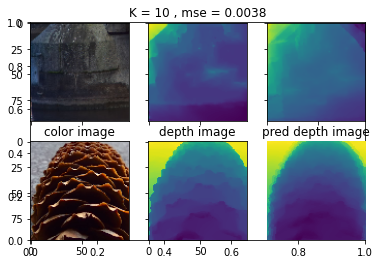

In [11]:
# more plots
knn = KNeighborsRegressor(n_neighbors= 7)
m = knn.fit(x_train, y_train)
ypred = m.predict(x_test)
mse = mean_squared_error(ypred, y_test)
f = plt.figure()
plt.title(f"K = 10 , mse = {mse :3.2}")
axarr = f.subplots(2,3)
plt.axis("off")
axarr[0,0].imshow(colorimg_test[212])
axarr[0,1].imshow(y_test[212].reshape(96,96,1))
axarr[0,2].imshow(ypred[212].reshape(96,96,1))
axarr[1,0].imshow(colorimg_test[240])
axarr[1,1].imshow(y_test[240].reshape(96,96,1))
axarr[1,2].imshow(ypred[240].reshape(96,96,1))
axarr[1,0].set_title('color image')
axarr[1,1].set_title('depth image')
axarr[1,2].set_title('pred depth image')
for ax in axarr.flat:
    ax.label_outer()

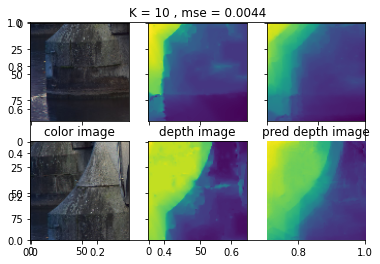

In [12]:
# more plots
knn = KNeighborsRegressor(n_neighbors= 10)
m = knn.fit(x_train, y_train)
ypred = m.predict(x_test)
mse = mean_squared_error(ypred, y_test)
f = plt.figure()
plt.title(f"K = 10 , mse = {mse :3.2}")
axarr = f.subplots(2,3)
plt.axis("off")
axarr[0,0].imshow(colorimg_test[19])
axarr[0,1].imshow(y_test[19].reshape(96,96,1))
axarr[0,2].imshow(ypred[19].reshape(96,96,1))
axarr[1,0].imshow(colorimg_test[99])
axarr[1,1].imshow(y_test[99].reshape(96,96,1))
axarr[1,2].imshow(ypred[99].reshape(96,96,1))
axarr[1,0].set_title('color image')
axarr[1,1].set_title('depth image')
axarr[1,2].set_title('pred depth image')
for ax in axarr.flat:
    ax.label_outer()

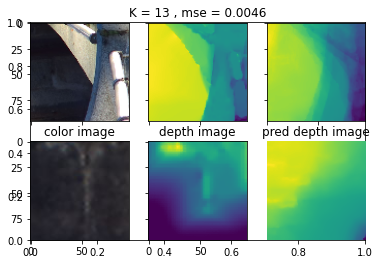

In [13]:
# more plots
knn = KNeighborsRegressor(n_neighbors= 13)
m = knn.fit(x_train, y_train)
ypred = m.predict(x_test)
mse = mean_squared_error(ypred, y_test)
f = plt.figure()
plt.title(f"K = 13 , mse = {mse :3.2}")
axarr = f.subplots(2,3)
plt.axis("off")
axarr[0,0].imshow(colorimg_test[211])
axarr[0,1].imshow(y_test[211].reshape(96,96,1))
axarr[0,2].imshow(ypred[211].reshape(96,96,1))
axarr[1,0].imshow(colorimg_test[189])
axarr[1,1].imshow(y_test[189].reshape(96,96,1))
axarr[1,2].imshow(ypred[189].reshape(96,96,1))
axarr[1,0].set_title('color image')
axarr[1,1].set_title('depth image')
axarr[1,2].set_title('pred depth image')
for ax in axarr.flat:
    ax.label_outer()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 15.0)

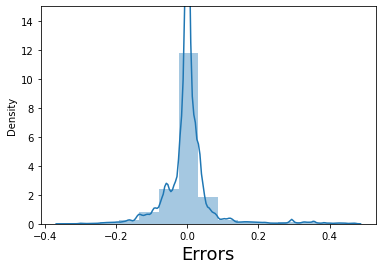

In [14]:
# residuals 
res = ypred - y_test
fig = plt.figure()
sns.distplot(res, bins = 15)                
plt.xlabel('Errors', fontsize = 18)  
plt.ylim(0,15)

In [15]:
res.shape

(280, 9216)


 Residuals summary 
 count    9216.000000
mean        0.014474
std         0.015645
min        -0.031379
25%         0.015808
50%         0.021212
75%         0.023005
max         0.027664
dtype: float64


Text(0, 0.5, 'predicted depth')

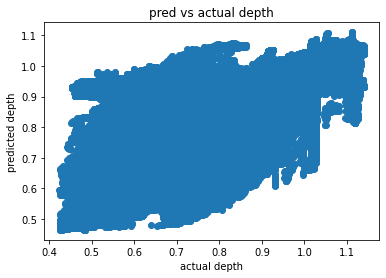

In [16]:
# plot res vs coefs 
res = pd.Series(res[1])

print("\n Residuals summary \n",res.describe())

fig = plt.figure()
plt.scatter(y_test, ypred)
plt.title("pred vs actual depth")
plt.xlabel("actual depth")
plt.ylabel("predicted depth")